In [2]:
import os
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib widget

In [25]:
# results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_cross_context_stimulus_decoding_20260129_231436/"
# results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_cross_context_stimulus_decoding_10ms_step_20260129_234046/"
# results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/cross_context_lick_decoding_10ms_step_20_units_20260130_141819/"
# results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/cross_context_lick_decoding_aud_stim_10ms_step_20_units_20260130_180221/"
# results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/cross_context_lick_decoding_aud_stim_10ms_step_20_units_20260130_223635/"

# results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/cross_context_vis_stimulus_decoding_10ms_step_20_units_0/" #whole dataset, vis stim
# results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/cross_context_aud_stimulus_decoding_10ms_step_20_units_0/" #whole dataset, aud stim
#whole dataset, licks, all stim together

# results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_vis_pref_units_decode_licks_across_context_20260205_235724/"#vis context preferring units, decode licks
# results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_aud_pref_units_decode_licks_across_context_20260206_001101/"#aud context preferring units, decode licks


# results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_aud_pref_units_decode_aud_stim_across_context_20260206_183448/" #
# results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_aud_pref_units_decode_vis_stim_across_context_20260206_183853/"


# results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/cross_context_aud_stim_decoding_all_units_0/" #whole dataset, aud stim, all units

results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/cross_context_vis_stim_decoding_all_units_0/" #whole dataset, vis stim, all units


In [3]:
# results_table=pl.read_parquet(results_path)

In [ ]:
# results_table.filter(
#     pl.col('structure').eq('MOs'),
#     pl.col('bin_center').eq(0.125),
#     pl.col('train_test_split_label').eq('train_vis_test_vis'),
# )['balanced_accuracy_test'].mean()


In [ ]:
# results_table.filter(
#     pl.col('structure').eq('PL'),
#     pl.col('bin_center').eq(0.125),
#     pl.col('train_test_split_label').eq('train_vis_test_vis'),
# )


In [ ]:
# results_table['structure'].unique()

In [ ]:
# results_table

In [26]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.parquet"
session_table=pl.read_parquet(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')==[],
    pl.col('is_engaged'),
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [27]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    'train_test_split_label'
    # 'unit_criteria',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [28]:
# session-wise average decoding accuracy
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

#add total n units, cross-modal dprime, n good blocks?

new_results_session_df = (
    pl.scan_parquet(results_path)
    .filter(
        pl.col('session_id').is_in(dr_session_list),
    )
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
    )
    #get total n units
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    #join on session table to get cross-modal dprime, etc.
    .join(
        other=session_table.filter(
            pl.col('session_id').is_in(dr_session_list)
        ).select(
            'session_id',
            'n_passing_blocks',
            'cross_modality_dprime_vis_blocks',
            'cross_modality_dprime_aud_blocks',
        ).lazy(),
        on='session_id',
        how='left',
    )
    # get the means for each recording over repeats:
    .group_by(grouping_cols | {'shift_idx', 'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                               'cross_modality_dprime_aud_blocks', 'total_n_units'}, maintain_order=True
    )
    .agg(
        pl.col('balanced_accuracy_test').mean(), # over repeats
    )
    .group_by(grouping_cols - {'bin_center'} | {'shift_idx', 'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                               'cross_modality_dprime_aud_blocks', 'total_n_units'}, maintain_order=True
    )
    .agg(
        pl.col('bin_center','balanced_accuracy_test').sort_by('bin_center')
    )
    .sort('session_id', 'structure', 'unit_subsample_size', 'train_test_split_label', descending=False)
    .collect()
)


In [29]:
new_results_session_df

structure,n_passing_blocks,total_n_units,bin_size,cross_modality_dprime_aud_blocks,unit_subsample_size,shift_idx,train_test_split_label,electrode_group_names,session_id,time_aligned_to,cross_modality_dprime_vis_blocks,bin_center,balanced_accuracy_test
str,i64,u64,f64,list[f64],u16,i16,str,list[str],str,enum,list[f64],list[f64],list[f64]
"""AUDp""",5,67,0.01,"[1.438862, 0.126049, 2.223431]",null,null,"""train_aud_test_aud""","[""probeC""]","""626791_2022-08-15""","""stim_start_time""","[3.073268, 1.491976, 1.879376]","[-0.095, -0.085, … 0.595]","[0.597098, 0.511243, … 0.578047]"
"""AUDp""",5,67,0.01,"[1.438862, 0.126049, 2.223431]",null,null,"""train_aud_test_vis""","[""probeC""]","""626791_2022-08-15""","""stim_start_time""","[3.073268, 1.491976, 1.879376]","[-0.095, -0.085, … 0.595]","[0.499772, 0.501545, … 0.650321]"
"""AUDp""",5,67,0.01,"[1.438862, 0.126049, 2.223431]",null,null,"""train_vis_test_aud""","[""probeC""]","""626791_2022-08-15""","""stim_start_time""","[3.073268, 1.491976, 1.879376]","[-0.095, -0.085, … 0.595]","[0.5, 0.515399, … 0.627717]"
"""AUDp""",5,67,0.01,"[1.438862, 0.126049, 2.223431]",null,null,"""train_vis_test_vis""","[""probeC""]","""626791_2022-08-15""","""stim_start_time""","[3.073268, 1.491976, 1.879376]","[-0.095, -0.085, … 0.595]","[0.499878, 0.570379, … 0.675466]"
"""AUDpo""",5,112,0.01,"[1.438862, 0.126049, 2.223431]",null,null,"""train_aud_test_aud""","[""probeC""]","""626791_2022-08-15""","""stim_start_time""","[3.073268, 1.491976, 1.879376]","[-0.095, -0.085, … 0.595]","[0.50873, 0.434524, … 0.662591]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SSp""",5,942,0.01,"[1.987737, 2.147704, 1.021441]",null,null,"""train_vis_test_vis""","[""probeA"", ""probeB"", … ""probeF""]","""761583_2024-12-17""","""stim_start_time""","[2.293226, 2.536261, -0.007621]","[-0.095, -0.085, … 0.595]","[0.4609375, 0.479273, … 0.73393]"
"""VPM""",5,222,0.01,"[1.987737, 2.147704, 1.021441]",null,null,"""train_aud_test_aud""","[""probeC""]","""761583_2024-12-17""","""stim_start_time""","[2.293226, 2.536261, -0.007621]","[-0.095, -0.085, … 0.595]","[0.517241, 0.524015, … 0.555556]"
"""VPM""",5,222,0.01,"[1.987737, 2.147704, 1.021441]",null,null,"""train_aud_test_vis""","[""probeC""]","""761583_2024-12-17""","""stim_start_time""","[2.293226, 2.536261, -0.007621]","[-0.095, -0.085, … 0.595]","[0.495748, 0.495337, … 0.670194]"


In [30]:
def plot_cross_context_decoding_single_session(results_df,sel_structure,sel_session,decoder_string,savepath=None,bin_center_offset=0):
    bin_centers=results_df.filter(
        pl.col('structure').eq(sel_structure),
        pl.col('train_test_split_label').eq('train_aud_test_aud'),
        pl.col('session_id').eq(sel_session),   
    )['bin_center'].item()+bin_center_offset

    train_aud_test_aud=results_df.filter(
        pl.col('structure').eq(sel_structure),
        pl.col('train_test_split_label').eq('train_aud_test_aud'),  
        pl.col('session_id').eq(sel_session), 
    )['balanced_accuracy_test'].item()

    train_aud_test_vis=results_df.filter(
        pl.col('structure').eq(sel_structure),
        pl.col('train_test_split_label').eq('train_aud_test_vis'),   
        pl.col('session_id').eq(sel_session),
    )['balanced_accuracy_test'].item()

    train_vis_test_vis=results_df.filter(
        pl.col('structure').eq(sel_structure),
        pl.col('train_test_split_label').eq('train_vis_test_vis'),   
        pl.col('session_id').eq(sel_session),
    )['balanced_accuracy_test'].item()

    train_vis_test_aud=results_df.filter(
        pl.col('structure').eq(sel_structure),
        pl.col('train_test_split_label').eq('train_vis_test_aud'), 
        pl.col('session_id').eq(sel_session),  
    )['balanced_accuracy_test'].item()


    fig,ax=plt.subplots(1,2,figsize=(6,3.5),sharex=True,sharey=True)
    ax[0].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax[0].axvline(0,color='k',linewidth=0.5,linestyle='--')
    ax[0].plot(bin_centers,train_aud_test_aud,label='train aud test aud')
    ax[0].plot(bin_centers,train_aud_test_vis,label='train aud test vis')
    ax[0].set_xlabel('time rel to stim onset (s)')
    ax[0].set_ylabel(decoder_string+' decoding accuracy')
    ax[0].set_title('train in aud context')
    ax[0].legend()

    ax[1].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
    ax[1].axvline(0,color='k',linewidth=0.5,linestyle='--')
    ax[1].plot(bin_centers,train_vis_test_vis,label='train vis test vis')
    ax[1].plot(bin_centers,train_vis_test_aud,label='train vis test aud')
    ax[1].set_xlabel('time rel to stim onset (s)')
    ax[1].set_title('train in vis context')
    ax[1].legend()

    fig.suptitle(f'{sel_structure}; {sel_session}')

    fig.tight_layout()

    if savepath is not None:
        fig.savefig(os.path.join(savepath,f'decode_{decoder_string}_{sel_session}_{sel_structure}.png'), 
                    bbox_inches='tight', dpi=200, transparent=False, format='png', pad_inches=0.1)
        plt.close(fig)


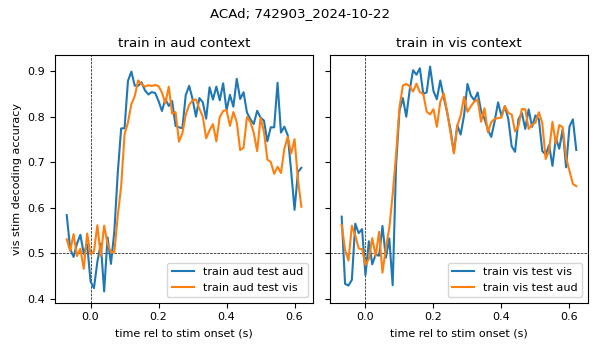

In [31]:
sel_structure='ACAd'
sel_session='742903_2024-10-22'
decoder_string='vis stim'
plot_cross_context_decoding_single_session(new_results_session_df,sel_structure,sel_session,decoder_string,bin_center_offset=0.025)

In [60]:
#save plots for all structures in this session
sel_session='742903_2024-10-22'
decoder_string='vis stim'
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2026-01-30-cross_context_decoding\example session"

for sel_structure in new_results_session_df.filter(pl.col('session_id').eq(sel_session))['structure'].unique():
    plot_cross_context_decoding_single_session(new_results_session_df,sel_structure,sel_session,decoder_string,savepath,bin_center_offset=0.025)

In [ ]:
# new_results_session_df.filter(
#     pl.col('structure').eq(sel_structure),
#     pl.col('train_test_split_label').eq('train_aud_test_aud'),   
# )['balanced_accuracy_test'].item()

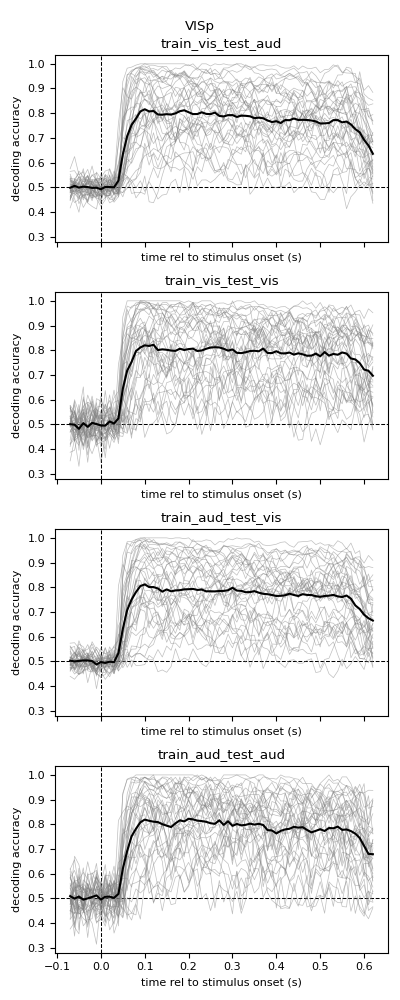

In [32]:
#TODO: analyze across sessions!

train_test_labels=[
    'train_vis_test_aud',
    'train_vis_test_vis',
    'train_aud_test_vis',
    'train_aud_test_aud'
]

sel_structure='VISp'

timebins=new_results_session_df['bin_center'][0]+0.025

fig,ax=plt.subplots(4,1,figsize=(4,10),sharex=True,sharey=True)

for tt,label in enumerate(train_test_labels):
    array=np.vstack(new_results_session_df.filter(
        pl.col('structure').eq(sel_structure),
        pl.col('train_test_split_label').eq(label),   
    )['balanced_accuracy_test'].to_numpy())

    
    ax[tt].axhline(0.5,color='k',linestyle='--',linewidth=0.75)
    ax[tt].axvline(0,color='k',linestyle='--',linewidth=0.75)
    ax[tt].plot(timebins,array.T,color='grey',linewidth=0.5,alpha=0.5)
    ax[tt].plot(timebins,np.nanmean(array,axis=0),'k')
    ax[tt].set_xlabel('time rel to stimulus onset (s)')
    ax[tt].set_ylabel('decoding accuracy')
    ax[tt].set_title(label)

fig.suptitle(sel_structure)
fig.tight_layout()

In [11]:
def plot_cross_context_decoding(results_df,sel_structure,decoder_string,savepath=None,bin_center_offset=0):

    timebins=results_df['bin_center'][0]+bin_center_offset

    fig,ax=plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True)

    train_vis_test_aud=np.vstack(results_df.filter(
        pl.col('structure').eq(sel_structure),
        pl.col('train_test_split_label').eq('train_vis_test_aud'),   
    )['balanced_accuracy_test'].to_numpy())
    train_vis_test_vis=np.vstack(results_df.filter(
        pl.col('structure').eq(sel_structure),
        pl.col('train_test_split_label').eq('train_vis_test_vis'),   
    )['balanced_accuracy_test'].to_numpy())

    train_aud_test_vis=np.vstack(results_df.filter(
        pl.col('structure').eq(sel_structure),
        pl.col('train_test_split_label').eq('train_aud_test_vis'),   
    )['balanced_accuracy_test'].to_numpy())
    train_aud_test_aud=np.vstack(results_df.filter(
        pl.col('structure').eq(sel_structure),
        pl.col('train_test_split_label').eq('train_aud_test_aud'),   
    )['balanced_accuracy_test'].to_numpy())

    n_sessions=train_vis_test_vis.shape[0]

    train_vis_test_aud_mean=np.nanmean(train_vis_test_aud,axis=0)
    train_vis_test_aud_sem=stats.sem(train_vis_test_aud,axis=0)
    train_vis_test_vis_mean=np.nanmean(train_vis_test_vis,axis=0)
    train_vis_test_vis_sem=stats.sem(train_vis_test_vis,axis=0)

    train_aud_test_vis_mean=np.nanmean(train_aud_test_vis,axis=0)
    train_aud_test_vis_sem=stats.sem(train_aud_test_vis,axis=0)
    train_aud_test_aud_mean=np.nanmean(train_aud_test_aud,axis=0)
    train_aud_test_aud_sem=stats.sem(train_aud_test_aud,axis=0)

    ax[0].axhline(0.5,color='k',linestyle='--',linewidth=0.75)
    ax[0].axvline(0,color='k',linestyle='--',linewidth=0.75)

    ax[0].plot(timebins,train_vis_test_vis_mean,'tab:blue',label='train_vis_test_vis')
    ax[0].fill_between(timebins,train_vis_test_vis_mean-train_vis_test_vis_sem,
                    train_vis_test_vis_mean+train_vis_test_vis_sem,
                    color='tab:blue',alpha=0.3)

    ax[0].plot(timebins,train_vis_test_aud_mean,'tab:orange',label='train_vis_test_aud')
    ax[0].fill_between(timebins,train_vis_test_aud_mean-train_vis_test_aud_sem,
                    train_vis_test_aud_mean+train_vis_test_aud_sem,
                    color='tab:orange',alpha=0.3)

    ax[0].set_xlabel('time rel to stimulus onset (s)')
    ax[0].set_ylabel(decoder_string+' decoding accuracy')
    ax[0].set_title('train in visual context')
    ax[0].legend()

    ax[1].axhline(0.5,color='k',linestyle='--',linewidth=0.75)
    ax[1].axvline(0,color='k',linestyle='--',linewidth=0.75)

    ax[1].plot(timebins,train_aud_test_aud_mean,'tab:blue',label='train_aud_test_aud')
    ax[1].fill_between(timebins,train_aud_test_aud_mean-train_aud_test_aud_sem,
                    train_aud_test_aud_mean+train_aud_test_aud_sem,
                    color='tab:blue',alpha=0.3)

    ax[1].plot(timebins,train_aud_test_vis_mean,'tab:orange',label='train_aud_test_vis')
    ax[1].fill_between(timebins,train_aud_test_vis_mean-train_aud_test_vis_sem,
                    train_aud_test_vis_mean+train_aud_test_vis_sem,
                    color='tab:orange',alpha=0.3)

    ax[1].set_xlabel('time rel to stimulus onset (s)')
    # ax[1].set_ylabel('decoding accuracy')
    ax[1].set_title('train in auditory context')
    ax[1].legend()

    #show other 2 comparisons - color for test set, line pattern for train set

    fig.suptitle(f'{sel_structure} (n={n_sessions})',fontsize=14)
    fig.tight_layout()

    if savepath is not None:
        fig.savefig(os.path.join(savepath,f'{sel_structure}_decode_{decoder_string}.png'), 
                    bbox_inches='tight', dpi=200, transparent=False, format='png', pad_inches=0.1)
        plt.close(fig)

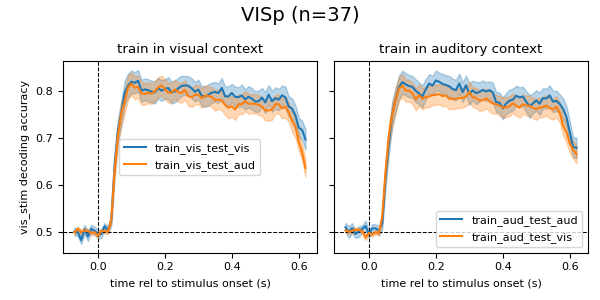

In [12]:
sel_structure='VISp'
decoder_string='vis_stim'
plot_cross_context_decoding(new_results_session_df,sel_structure,decoder_string,savepath=None,bin_center_offset=0.025)

In [47]:
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2026-01-30-cross_context_decoding\across sessions all units"
decoder_string='vis_stim'
for sel_structure in new_results_session_df['structure'].unique():
    plot_cross_context_decoding(new_results_session_df,sel_structure,decoder_string,savepath=savepath,bin_center_offset=0.025)

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_11956\2630415264.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True)
